<h3><u><center> Defining Problem Statement and Analysing basic metrics </center></u></h3>

As a data scientist at Apollo Hospitals our task is to do the following:
<ul>
    <li> Which variables are significant in predicting the reason for hospitalization for different regions </li>
    <li> How well some variables like viral load, smoking, Severity Level describe the hospitalization charges </li>
</ul>

<b> Dataset Definition: </b>

<ul>
    <li> Age: This is an integer indicating the age of the primary beneficiary (excluding those above 64 years, since they are generally covered by the government) </li>
    <li> Sex: This is the policy holder's gender, either male or female </li>
    <li> Viral Load: Viral load refers to the amount of virus in an infected person's blood </li>
    <li> Severity Level (0-5): This is an integer indicating how severe the patient is
    <li> Smoker: This is yes or no depending on whether the insured regularly smokes tobacco. </li>
    <li> Region: This is the beneficiary's place of residence in Delhi, divided into four geographic regions - northeast, southeast, southwest, or northwest </li>
    <li> Hospitalization charges: Individual medical costs billed to health insurance </li>
</ul>
    
<b><u> Importing libraries </u></b>

In [162]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings # to supress any warnings coming out
warnings.filterwarnings("ignore")

In [377]:
from scipy.stats import f_oneway #One-way anova
from scipy.stats import ttest_ind # 2 Sample independent T-Test
from scipy.stats import chi2_contingency #Chi2 test

# Tests for Normality
from scipy.stats import shapiro #Shapiro Wilk Test 
from scipy.stats import normaltest # D’Agostino and Pearson’s K2 Test
from scipy.stats import probplot #PP plot for normality
import statsmodels.api as sm #for QQ plot
import pylab #for QQ plot

from scipy.stats import levene #to check whether variances are similar
from scipy.stats import boxcox
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

In [164]:
ap = pd.read_csv("scaler_apollo_hospitals.csv")
ap.head()

,Unnamed: 0,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,0,19,female,yes,southwest,9.30,0,42212
1,1,18,male,no,southeast,11.26,1,4314
2,2,28,male,no,southeast,11.00,3,11124
3,3,33,male,no,northwest,7.57,0,54961
4,4,32,male,no,northwest,9.63,0,9667


Dropping the first column since it just shows the indices

In [165]:
ap.columns[0]

'Unnamed: 0'

In [166]:
ap.drop(ap.columns[0], axis = 1, inplace = True)
ap

,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,19,female,yes,southwest,9.30,0,42212
1,18,male,no,southeast,11.26,1,4314
2,28,male,no,southeast,11.00,3,11124
3,33,male,no,northwest,7.57,0,54961
4,32,male,no,northwest,9.63,0,9667
...,...,...,...,...,...,...,...
1333,50,male,no,northwest,10.32,3,26501
1334,18,female,no,northeast,10.64,0,5515
1335,18,female,no,southeast,12.28,0,4075
1336,21,female,no,southwest,8.60,0,5020


In [167]:
ap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      1338 non-null   int64  
 1   sex                      1338 non-null   object 
 2   smoker                   1338 non-null   object 
 3   region                   1338 non-null   object 
 4   viral load               1338 non-null   float64
 5   severity level           1338 non-null   int64  
 6   hospitalization charges  1338 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 73.3+ KB


#### <u>Data type correction, Data description</u>

In [293]:
for col in ap.columns[ap.dtypes == "object"].tolist():
    ap[col] = ap[col].astype("category")
    
ap["severity level"] = ap["severity level"].astype("category")

In [294]:
ap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   age                      1338 non-null   int64   
 1   sex                      1338 non-null   category
 2   smoker                   1338 non-null   category
 3   region                   1338 non-null   category
 4   viral load               1338 non-null   float64 
 5   severity level           1338 non-null   category
 6   hospitalization charges  1338 non-null   int64   
dtypes: category(4), float64(1), int64(2)
memory usage: 37.4 KB


In [295]:
ap.describe()

,age,viral load,hospitalization charges
count,1338.000000,1338.000000,1338.000000
mean,39.207025,10.221233,33176.058296
std,14.049960,2.032796,30275.029296
min,18.000000,5.320000,2805.000000
25%,27.000000,8.762500,11851.000000
50%,39.000000,10.130000,23455.000000
75%,51.000000,11.567500,41599.500000
max,64.000000,17.710000,159426.000000


In [296]:
ap.describe(include = "category").T

,count,unique,top,freq
sex,1338,2,male,676
smoker,1338,2,no,1064
region,1338,4,southeast,364
severity level,1338,6,0,574


<b><u> Missing value check </u></b>

In [172]:
ap.isnull().sum()

age                        0
sex                        0
smoker                     0
region                     0
viral load                 0
severity level             0
hospitalization charges    0
dtype: int64

In [297]:
for col in ap.columns[ap.dtypes == "category"]:
    print(ap[col].value_counts(), end = "\n\n")
    print(ap[col].value_counts(normalize = True), end = "\n")
    print("----------------------------------------------------------------------------------")

male      676
female    662
Name: sex, dtype: int64

male      0.505232
female    0.494768
Name: sex, dtype: float64
----------------------------------------------------------------------------------
no     1064
yes     274
Name: smoker, dtype: int64

no     0.795217
yes    0.204783
Name: smoker, dtype: float64
----------------------------------------------------------------------------------
southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64

southeast    0.272048
northwest    0.242900
southwest    0.242900
northeast    0.242152
Name: region, dtype: float64
----------------------------------------------------------------------------------
0    574
1    324
2    240
3    157
4     25
5     18
Name: severity level, dtype: int64

0    0.428999
1    0.242152
2    0.179372
3    0.117339
4    0.018685
5    0.013453
Name: severity level, dtype: float64
----------------------------------------------------------------------------------


#### <u>Outlier Detection</u>

In [174]:
def printoutl(col):
    if (col.dtype != 'int64' and col.dtype != 'float64'):
        return "Incorrect Datatype"
    
    q1 = np.quantile(col, 0.25)
    q2 = np.quantile(col, 0.50)
    q3 = np.quantile(col, 0.75)
    IQR = q3 - q1
    min_outlier = q1 - 1.5*(IQR)
    max_outlier = q3 + 1.5*(IQR)

    return col[(col > max_outlier) | (col < min_outlier)].count()


In [175]:
for col in ap.columns:
    print("Column: ", col, "\n Number of outliers:", printoutl(ap[col]))

Column:  age 
 Number of outliers: 0
Column:  sex 
 Number of outliers: Incorrect Datatype
Column:  smoker 
 Number of outliers: Incorrect Datatype
Column:  region 
 Number of outliers: Incorrect Datatype
Column:  viral load 
 Number of outliers: 9
Column:  severity level 
 Number of outliers: 0
Column:  hospitalization charges 
 Number of outliers: 139


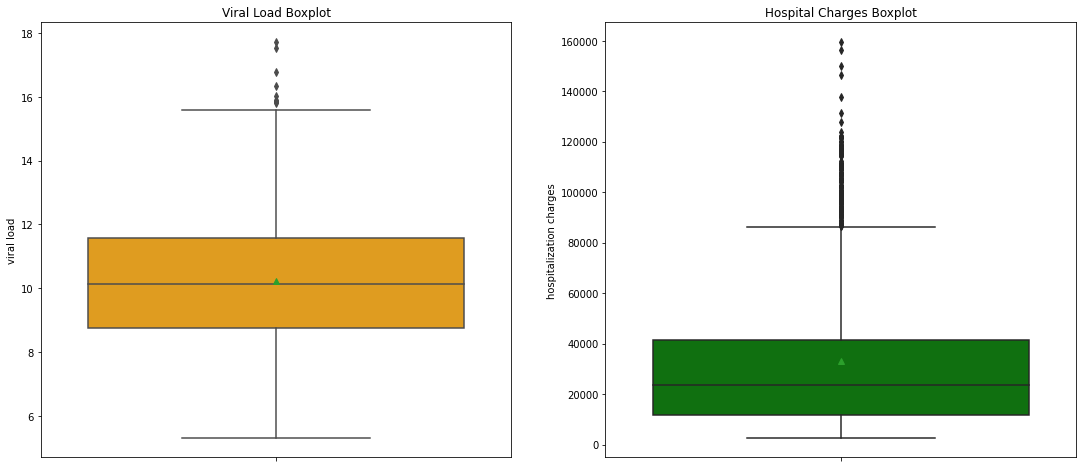

In [176]:
fig, axs = plt.subplots(nrows = 1,  ncols = 2,  figsize=(5, 8))

sns.boxplot(data = ap, y = "viral load", color = "orange", showmeans = True, ax = axs[0]).set(title = "Viral Load Boxplot")
sns.boxplot(data = ap, y = "hospitalization charges", color = "green", showmeans = True, ax = axs[1]).set(
    title = "Hospital Charges Boxplot")

plt.subplots_adjust(right = 3)
plt.show()

<h3><u><center> Exploratory Data Analysis </center></u></h3>

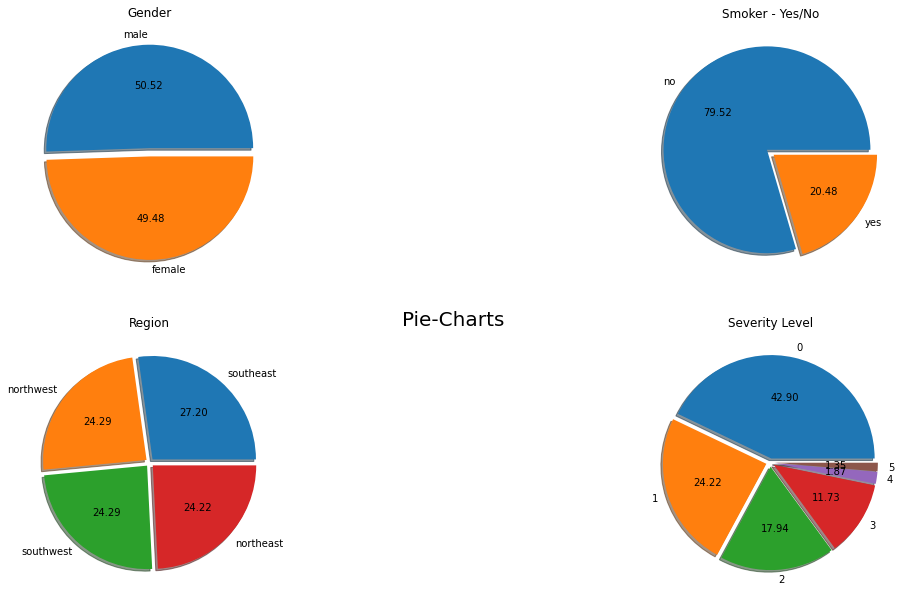

In [306]:
fig, axs = plt.subplots(nrows = 2,  ncols = 2,  figsize=(8, 4))

sex = ap.sex.value_counts()
smoke = ap.smoker.value_counts()
reg = ap.region.value_counts()
sl = ap["severity level"].value_counts()

axs[0][0].pie(x = sex, explode=([0.04] * len(sex)), 
           labels = sex.index.tolist(), autopct="%.2f", shadow=True)
axs[0][1].pie(x = smoke, explode=([0.04] * len(smoke)), 
           labels = smoke.index.tolist(), autopct="%.2f", shadow=True)
axs[1][0].pie(x = reg, explode=([0.04] * len(reg)), 
           labels = reg.index.tolist(), autopct="%.2f", shadow=True)
axs[1][1].pie(x = sl, explode=([0.04] * len(sl)), 
           labels = sl.index.tolist(), autopct="%.2f", shadow=True)

fig.suptitle('Pie-Charts', x = 1.1, y = 1.1, fontsize=20)
axs[0][0].set_title('Gender')
axs[0][1].set_title('Smoker - Yes/No')
axs[1][0].set_title('Region')
axs[1][1].set_title('Severity Level')

plt.subplots_adjust(right = 2.1, top = 2.1)
plt.show()

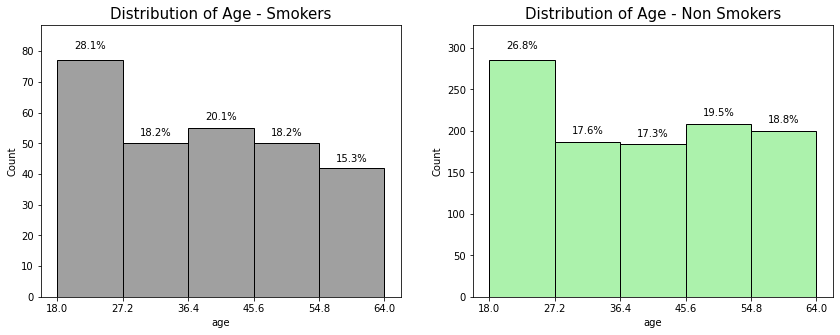

In [364]:
fig, axs = plt.subplots(nrows = 1,  ncols = 2,  figsize=(8, 5))

y_smoke = ap[ap["smoker"] == "yes"]
n_smoke = ap[ap["smoker"] == "no"]

bin_edges = np.histogram_bin_edges(ap["age"], bins = 5).round(1)

hist_1= sns.histplot(data = y_smoke, x = "age", bins = 5, color = "gray", ax = axs[0])
hist_1.margins(y = 0.15) #creating space for percentage label
total_1 = float(len(y_smoke))
    
for p in hist_1.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_1)
    x = p.get_x() + (p.get_width()/2)
    y = p.get_height() + (0.05 * p.get_height())
    hist_1.annotate(percentage, (x, y), ha='center') #ha = horizontal alignment of label

hist_2 = sns.histplot(data = n_smoke, x = "age", bins = 5, color = "lightgreen", ax = axs[1])
hist_2.margins(y = 0.15) #creating space for percentage label
total_2 = float(len(n_smoke))
    
for p in hist_2.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total_2)
    x = p.get_x() + (p.get_width()/2)
    y = p.get_height() + (0.05 * p.get_height())
    hist_2.annotate(percentage, (x, y), ha='center') #ha = horizontal alignment of label

axs[0].set_title('Distribution of Age - Smokers', fontsize = 15)
axs[0].set_xticks(bin_edges, labels=bin_edges)
axs[1].set_title('Distribution of Age - Non Smokers', fontsize = 15)
axs[1].set_xticks(bin_edges, labels=bin_edges)

plt.subplots_adjust(right = 1.5)
plt.show()

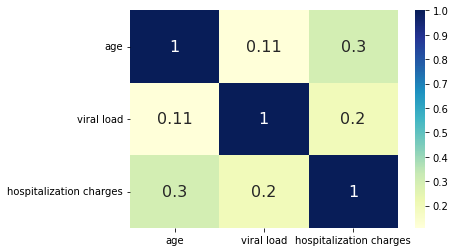

In [365]:
sns.heatmap(ap.corr(), cmap="YlGnBu", annot=True, annot_kws={"size": 16})
plt.show()

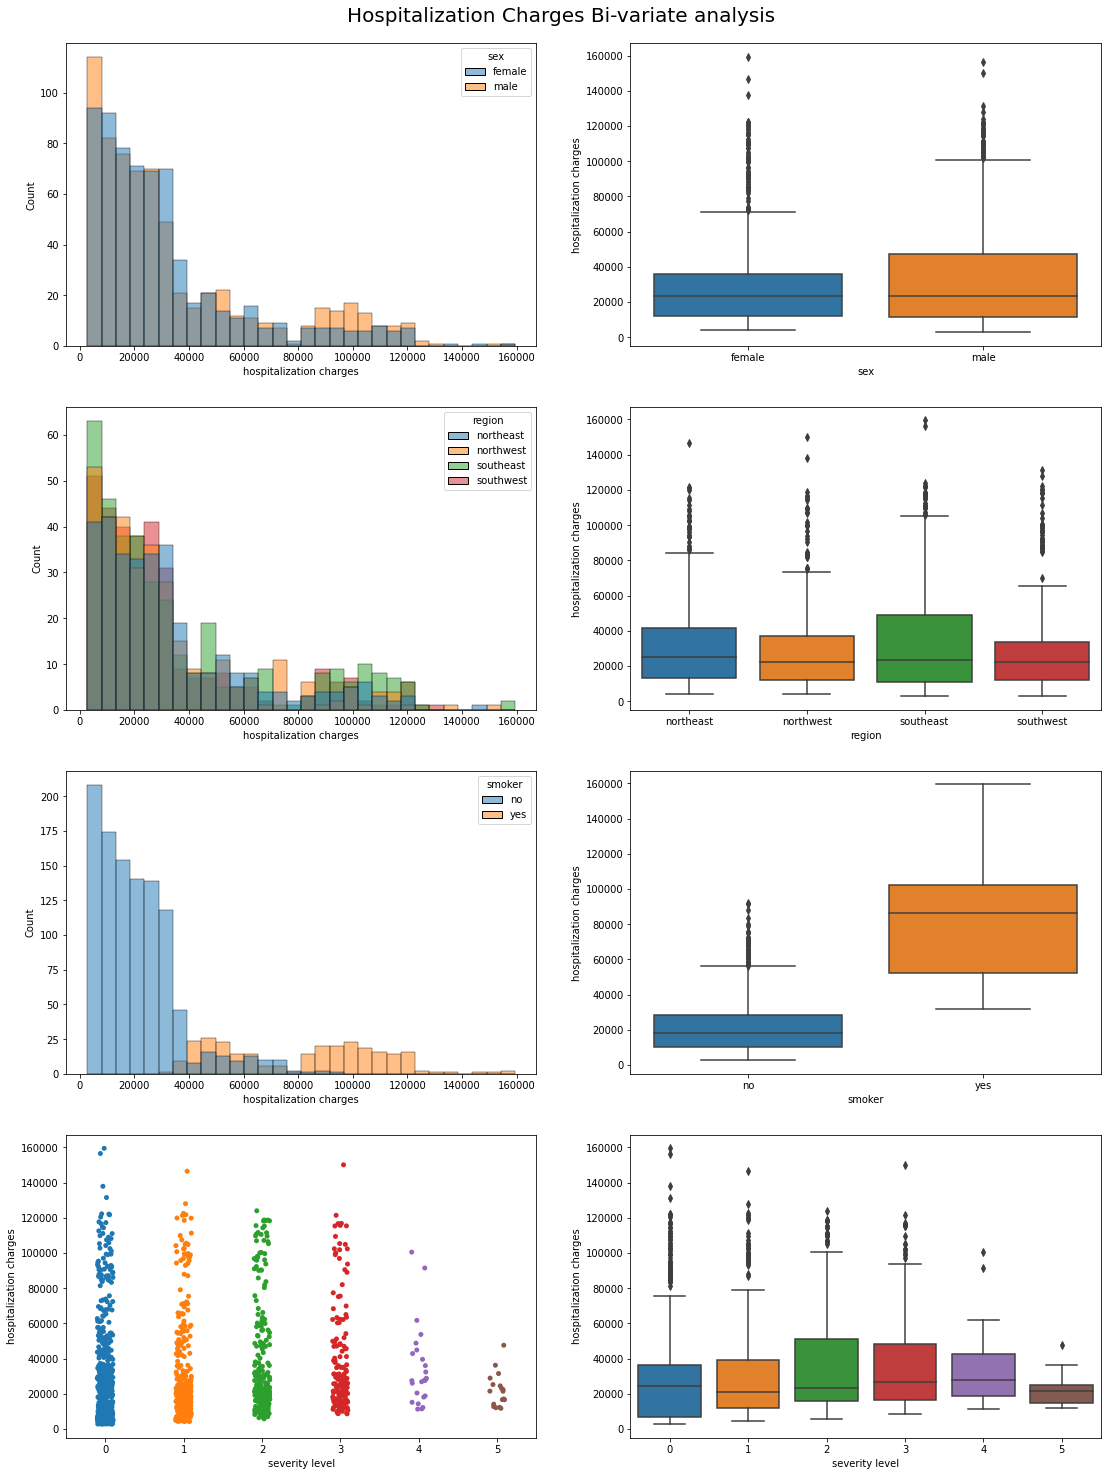

In [178]:
fig, axs = plt.subplots(nrows = 4,  ncols = 2,  figsize=(5, 5))
fig.suptitle('Hospitalization Charges Bi-variate analysis', x = 1.5, y = 4.1, fontsize=20)

sns.histplot(data = ap, x = "hospitalization charges", hue = "sex", ax = axs[0][0])
sns.boxplot(data = ap, y = "hospitalization charges", x = "sex", ax = axs[0][1])

sns.histplot(data = ap, x = "hospitalization charges", hue = "region", ax = axs[1][0])
sns.boxplot(data = ap, y = "hospitalization charges", x = "region", ax = axs[1][1])

sns.histplot(data = ap, x = "hospitalization charges", hue = "smoker", ax = axs[2][0])
sns.boxplot(data = ap, y = "hospitalization charges", x = "smoker", ax = axs[2][1])

#sns.histplot(data = ap, x = "hospitalization charges", hue = "severity level", ax = axs[3][0])
sns.stripplot(data = ap, y = "hospitalization charges", x = "severity level", ax = axs[3][0])
sns.boxplot(data = ap, y = "hospitalization charges", x = "severity level", ax = axs[3][1])

plt.subplots_adjust(right = 3, top = 4)
plt.show()

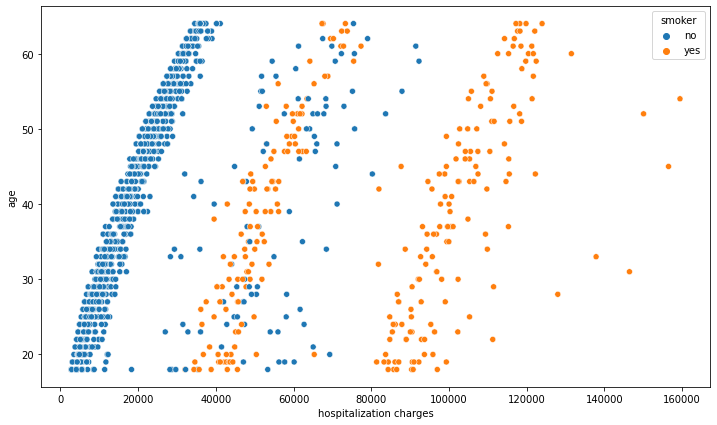

In [289]:
plt.figure(figsize=(12, 7))

sns.scatterplot(data = ap, x = 'hospitalization charges', y = 'age', hue = 'smoker')
plt.show()

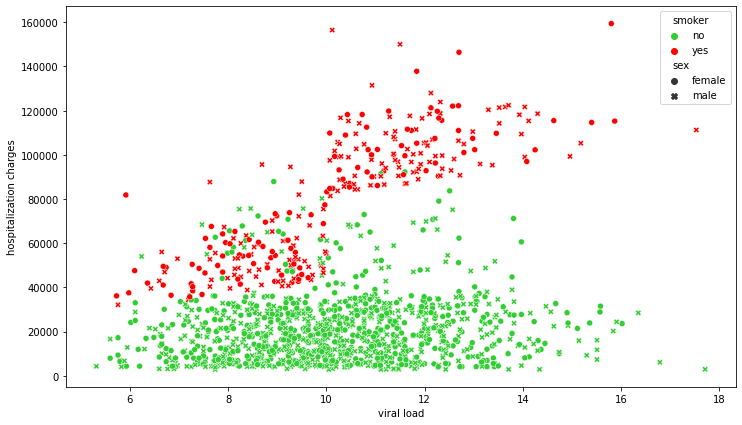

In [188]:
plt.figure(figsize=(12, 7))

sns.scatterplot(data = ap,  y = "hospitalization charges", x = "viral load", hue = "smoker", style="sex", 
                palette = ["limegreen", "red"])
plt.show()

<h3><center><u> Analysis w.r.t Region </u></center></h3>

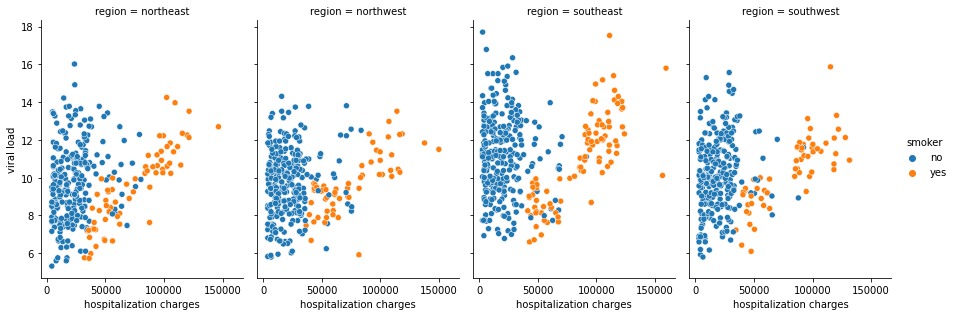

In [286]:
sns.relplot(data=ap, x = "hospitalization charges", y = "viral load", hue = "smoker", col="region", 
            height = 4.5, aspect = 0.7)

plt.show()

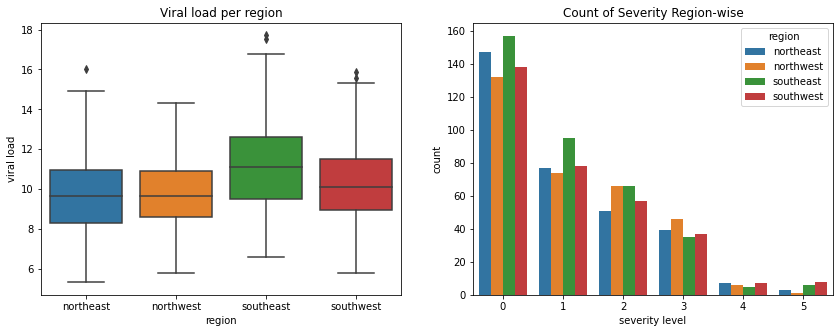

In [270]:
fig, axs = plt.subplots(nrows = 1,  ncols = 2, figsize=(8, 5))

sns.boxplot(data = ap, y = "viral load", x = "region", ax = axs[0]).set(title = "Viral load per region")
sns.countplot(data = ap, x = "severity level", hue = "region", ax = axs[1]).set(title = "Count of Severity Region-wise")

plt.subplots_adjust(right = 1.5)
plt.show()

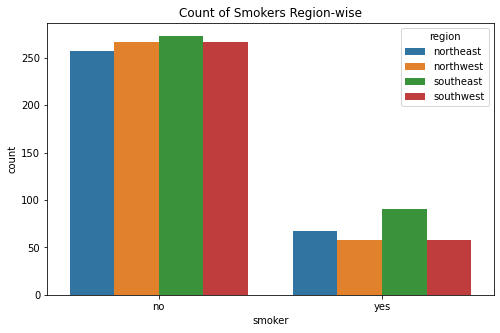

In [183]:
plt.figure(figsize=(8, 5))
sns.countplot(data = ap, x = "smoker", hue = "region").set(title = "Count of Smokers Region-wise")
plt.show()

<h3><center><u> Relationship b/w Severity, Viral Load and Smoking</u></center></h3>

In [202]:
grouped = ap.groupby(["severity level"])["viral load"].agg(['mean', 'median']).rename(
    columns={grouped.columns[0]:'Mean Viral load', grouped.columns[1]: 'Median Viral Load'})

grouped

,Mean Viral load,Median Viral Load
severity level,,
0,10.183693,10.100
1,10.207562,10.005
2,10.326083,10.545
3,10.228217,10.170
4,10.464000,9.880
5,9.868333,9.515


In [374]:
grouped = ap.groupby(["severity level"])["smoker"].value_counts(normalize = True).to_frame()

grouped

smoker
severity level              
0              no   0.799652
               yes  0.200348
1              no   0.811728
               yes  0.188272
2              no   0.770833
               yes  0.229167
3              no   0.751592
               yes  0.248408
4              no   0.880000
               yes  0.120000
5              no   0.944444
               yes  0.055556

<h4><u> Business Insights </u></h4>
<ul>
    <li> Dataset contains 1,338 non-null data points which are divided across 7 features. We are trying to figure out the reason why some people are getting ill more than others, and how well do some features predict hospitalization charges</li>
    <li> Dataset contains <b> no null values </b></li>
    <li> Using describe() function on numerical as well as categorical variables, we can infer the following :
        <ol>
            <li> Mean age of a patient hospitalized in Apollo Hospitals is 39</li>
            <li> Viral load ranges from 5.32 -> 17.71. The max value is quite far off from the standard deivations, this indicates that we are <b>dealing with outlier values</b> on the higher end of the values. These outliers might be due to issues with measuring equipment</li>
            <li> The average amount spent per hospitalization was Rs. 33,176. However, the median was much less than this value, this again indicates that there are <b>outliers</b> in our data which are inflating the mean</li>
            <li> Gender of patients visiting Apollo Hospitals is evenly distributed, just like the region paramter </li>
            <li> Non-smokers outnumber smokers by a lot. Patients who show less severe symptoms outnumber those who show more severe symptoms by a huge margin</li>
        </ol>
    <li> Hospitalization charges column has a lot of outliers in it as we had hypothesized</li>    
    <li> The distribution of age is quite even for the most part: Except for people from ages 18 to 27. <b> Smokers and non-smokers are evenly distributed among the age groups </b> which means prevelancy of smoking is not dependent on age group </li>
    <li> From our bi-variate analysis, we found that <b>males are more likely to incur higher treatment cost than females</b> </li>
    <li> People living in the <b>southeast</b> region spend <b>high amounts of money</b> for treatment as compared to other regions</li>
    <li> People who smoke spend <b>extremely high amounts of money</b> for their treatment. There is a big correlation here</li>
    <li> Severity level doesn't seem to have a correlation with hospital charges. People with higher severity spend lesser or average. Apollo needs to investigate further on this</li>
    <li><b>As age increases, there is a noticeable surge in treatment costs </b></li>
    <li> From visual interpretation, there doesn't seem to be a big correlation between the viral load and gender of the person. Also, gender doesn't play an import role in determining the cost of treatment</li>
    <li> Cost of treatment slightly increased w.r.t viral load, but the increase doesn't seem to be quantifiable. Also, people from SouthEast region have, on average, the highest viral load. </li>
</ul>

<h4><u> Recommendations </u></h4>
<ul> 
    <li> Apply tests to check all our hypothesis</li>
    <li> Apollo's <b>patients are almost evenly distributed </b> among gender, ages, and regions. This means Apollo needs to have <b>equipment and trained staff</b> to cater all the different combinations of customers </li>
    <li> In the SouthEast region, people have higher viral loads, proportion of smokers, and spend more on their treatment too. This may be due to poverty in those regions or squalid environmental conditions. <b> Therefore, Apollo should focus on setting up more hospitals in the SouthEast region and make sure it has experienced staff there to take care of the more ill patients</b>
    <li> There seems to be very little correlation between severity and other features like Hospitalization charges or viral load. This goes against our intuition that <b>more severe patients should require more treatment</b>. Apollo should gather more insights on this</li>
</ul>

<h3><u><center> Hypothesis Testing </center></u></h3>

<b><u><h3> Problem 1: Prove (or disprove) that the hospitalization charges of people who do smoking are greater than those who don't</h3></u></b>
<br>Types of variables : Hospitalization Charges (Continuous) v/s Smoker (Categorical - Yes and No)
<br> Test to be used: <b>2 Sample Right tailed independent T-Test</b>
<br> Assumptions: T-Test is parametric, hence population should follow <b>normal distribution</b>. All samples should be selected <b>independent</b> of each other

<br><b>Null Hyp</b> => Mean(charges occured by smokers) <= Mean(charges occured by non-smokers)
<br><b>Alt Hyp</b> => Mean(charges occured by smokers) > Mean(charges occured by non-smokers)

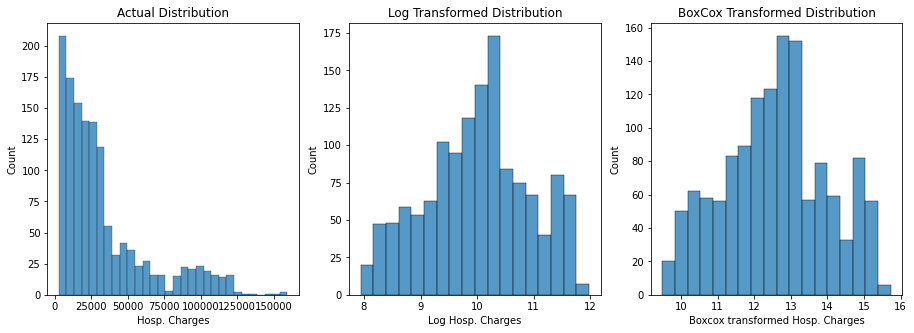

In [403]:
fig, axs = plt.subplots(nrows = 1,  ncols = 3,  figsize=(5, 5))
log_ap = np.log(ap["hospitalization charges"])
bx = boxcox(ap["hospitalization charges"])

sns.histplot(data = ap, x = "hospitalization charges", ax = axs[0]).set(
    title = "Actual Distribution", xlabel = "Hosp. Charges")
sns.histplot(x = log_ap , ax = axs[1]).set(
    title = "Log Transformed Distribution", xlabel = "Log Hosp. Charges")
sns.histplot(x = bx[0] , ax = axs[2]).set(
    title = "BoxCox Transformed Distribution", xlabel = "Boxcox transformed Hosp. Charges")

plt.subplots_adjust(right = 2.5)
plt.show()

<u><b> Checking if both samples belong from normal dist - SW Test and NormalTest (D’Agostino and Pearson’s K2 Test) </b></u>

Ho (Null hyp) => Normally distributed
<br>Ha (Alt hyp) => Not normally distributed

In [404]:
alpha = 0.1

w_stat, p_val = shapiro(ap["hospitalization charges"])
print("W-statistic", w_stat, "P-value", p_val)

if(p_val < alpha):
    print("Reject Null Hyp - Distribution is not normally distributed")
else:
    print("Fail to reject Null Hyp - Distribution is normally distributed")
    
w_stat, p_val = shapiro(log_ap)
print("\nW-statistic", w_stat, "P-value", p_val)

if(p_val < alpha):
    print("Reject Null Hyp - Log Transformed Distribution is not normally distributed")
else:
    print("Fail to reject Null Hyp - Log Transformed Distribution is normally distributed")
    
w_stat, p_val = shapiro(bx[0])
print("\nW-statistic", w_stat, "P-value", p_val)

if(p_val < alpha):
    print("Reject Null Hyp - BoxCox Transformed Distribution is not normally distributed")
else:
    print("Fail to reject Null Hyp - BoxCox Transformed Distribution is normally distributed")

W-statistic 0.8146882057189941 P-value 1.1505333015369624e-36
Reject Null Hyp - Distribution is not normally distributed

W-statistic 0.9831627607345581 P-value 2.286809977491977e-11
Reject Null Hyp - Log Transformed Distribution is not normally distributed

W-statistic 0.9835088849067688 P-value 3.241499776929224e-11
Reject Null Hyp - BoxCox Transformed Distribution is not normally distributed


In [406]:
# Checking if both samples belong from normal dist - Normal Test
# Ho (Null hyp) => Normally distributed
# Ha (Alt hyp) => Not normally distributed

alpha = 0.1

stat, p_val = normaltest(ap["hospitalization charges"])
print("Test statistic", stat, "P-value", p_val)

if(p_val < alpha):
    print("Reject Null Hyp - Distribution is not normally distributed")
else:
    print("Fail to reject Null Hyp - Distribution is normally distributed")
    
stat, p_val = normaltest(log_ap)
print("\nTest statistic", stat, "P-value", p_val)

if(p_val < alpha):
    print("Reject Null Hyp - Log Transformed Distribution is not normally distributed")
else:
    print("Fail to reject Null Hyp - Log Transformed Distribution is normally distributed")
    
stat, p_val = normaltest(bx[0])
print("\nTest statistic", stat, "P-value", p_val)

if(p_val < alpha):
    print("Reject Null Hyp - BoxCox Transformed Distribution is not normally distributed")
else:
    print("Fail to reject Null Hyp - BoxCox Transformed Distribution is normally distributed")

Test statistic 336.88533960007777 P-value 7.0190443866974234e-74
Reject Null Hyp - Distribution is not normally distributed

Test statistic 52.71977515219837 P-value 3.564891219118135e-12
Reject Null Hyp - Log Transformed Distribution is not normally distributed

Test statistic 54.42062992307923 P-value 1.5230366750063814e-12
Reject Null Hyp - BoxCox Transformed Distribution is not normally distributed


**Since we have failed to prove that our distribution is normal, we will use the assumption that because n is a large number, the population must be normally distributed**

In [420]:
y_smoke = ap[ap["smoker"] == "yes"]["hospitalization charges"]
n_smoke = ap[ap["smoker"] == "no"]["hospitalization charges"]

print(y_smoke.var() / n_smoke.var())

3.707890029470998


**Since, variances are unequal, we will use equal_var = False in our argument**
<br> **Setting confidence = 95%**

In [459]:
alpha = 0.05

t_stat, p_val = ttest_ind(y_smoke, n_smoke, equal_var = False, alternative="greater")

print("T-Score:", round(t_stat, 5))
print("P-Value:", round(p_val, 5))

if (p_val < alpha):
    print("Reject Null Hypothesis")
else:
    print("Fail to reject null hypothesis")

T-Score: 32.75186
P-Value: 0.0
Reject Null Hypothesis


**Therefore, with 95% confidence we can say that, on average, people who smoke pay much more charges than those who dont**

--------------------------------------------------------------------------------------------------------------------------------
<b><u><h3> Problem 2: Prove (or disprove) with statistical evidence that the viral load of females is different from that of males</h3></u></b>
<br>Types of variables : Viral load (Continuous) v/s Gender (Categorical - Male and Female)
<br> Test to be used: <b>2 tailed independent T-Test</b>
<br> Assumptions: T-Test is parametric, hence population should follow <b>normal distribution</b>. All samples should be selected <b>independent</b> of each other

<br><b>Null Hyp</b> => Mean(viral load of men) == Mean(viral load of women)
<br><b>Alt Hyp</b> => Mean(viral load of me) != Mean(viral load of women)

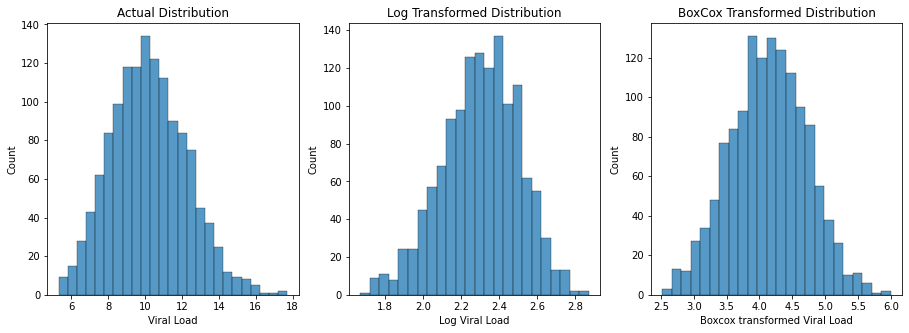

In [423]:
fig, axs = plt.subplots(nrows = 1,  ncols = 3,  figsize=(5, 5))
log_vl = np.log(ap["viral load"])
bx_vl = boxcox(ap["viral load"])

sns.histplot(data = ap, x = "viral load", ax = axs[0]).set(
    title = "Actual Distribution", xlabel = "Viral Load")
sns.histplot(x = log_vl , ax = axs[1]).set(
    title = "Log Transformed Distribution", xlabel = "Log Viral Load")
sns.histplot(x = bx_vl[0] , ax = axs[2]).set(
    title = "BoxCox Transformed Distribution", xlabel = "Boxcox transformed Viral Load")

plt.subplots_adjust(right = 2.5)
plt.show()

In [425]:
alpha = 0.1

w_stat, p_val = shapiro(ap["viral load"])
print("W-statistic", w_stat, "P-value", p_val)

if(p_val < alpha):
    print("Reject Null Hyp - Distribution is not normally distributed")
else:
    print("Fail to reject Null Hyp - Distribution is normally distributed")
    
w_stat, p_val = shapiro(log_vl)
print("\nW-statistic", w_stat, "P-value", p_val)

if(p_val < alpha):
    print("Reject Null Hyp - Log Transformed Distribution is not normally distributed")
else:
    print("Fail to reject Null Hyp - Log Transformed Distribution is normally distributed")
    
w_stat, p_val = shapiro(bx_vl[0])
print("\nW-statistic", w_stat, "P-value", p_val)

if(p_val < alpha):
    print("Reject Null Hyp - BoxCox Transformed Distribution is not normally distributed")
else:
    print("Fail to reject Null Hyp - BoxCox Transformed Distribution is normally distributed")
    
# D'Agostino - Pearson K2 Test for normality
stat, p_val = normaltest(bx_vl[0])
print("\nTest statistic", stat, "P-value", p_val)

if(p_val < alpha):
    print("Reject Null Hyp - BoxCox Transformed Distribution is not normally distributed")
else:
    print("Fail to reject Null Hyp - BoxCox Transformed Distribution is normally distributed")

W-statistic 0.9939048886299133 P-value 2.6902040190179832e-05
Reject Null Hyp - Distribution is not normally distributed

W-statistic 0.9945706725120544 P-value 8.888542652130127e-05
Reject Null Hyp - Log Transformed Distribution is not normally distributed

W-statistic 0.9985800385475159 P-value 0.34881141781806946
Fail to reject Null Hyp - BoxCox Transformed Distribution is normally distributed

Test statistic 2.8848769441490356 P-value 0.23635072079021927
Fail to reject Null Hyp - BoxCox Transformed Distribution is normally distributed


**As we can see, after performing BoxCox transformation, our sample is normally distributed. Hence we can go ahead with T-Test on this distribution**

In [426]:
m_viral_load = ap[ap["sex"] == "male"]["viral load"]
f_viral_load = ap[ap["sex"] == "female"]["viral load"]

print(m_viral_load.var() / f_viral_load.var())

1.0314909206920337


**Since, variances are almost equal, we will use equal_var = True in our argument**

In [439]:
alpha = 0.05

t_stat, p_val = ttest_ind(m_viral_load, f_viral_load, equal_var = True, alternative="two-sided")

print("T-Score:", round(t_stat, 5))
print("P-Value:", round(p_val, 5))

if (p_val < alpha):
    print("Reject Null Hypothesis")
else:
    print("Fail to reject null hypothesis")

T-Score: 1.69571
P-Value: 0.09017
Fail to reject null hypothesis


**Therefore, with 95% confidence, we can say that the mean viral loads of both men and women and equal**

--------------------------------------------------------------------------------------------------------------------------------
<b><u><h3> Problem 3: Is the proportion of smoking significantly different across different regions? </h3></u></b>
<br>Types of variables : Smoker(Categorical - Yes or No), Region (Categorical - 4 Regions)
<br> Test to be used: <b>Pearson's Chi-square test for independence</b>
<br> Assumptions: 
    <ol>
    <li> Variables should be discrete/categorical </li>
    <li> All observations should be independent </li>
    <li> Cells in contingency table should be mutually exclusive</li>
    <li> Min frequency of every cell >= 5 </li>
    </ol>


<br> Null Hyp => Both categories are <b> independent </b> of each other
<br> Alt Hyp => Both categories are <b> dependent </b> on each other
<br>**Note : We saw in the visual analysis, that the SouthEast Region had more smokers as compared to other regions**

In [431]:
ct = pd.crosstab(ap["smoker"], ap["region"])
ct

region,northeast,northwest,southeast,southwest
smoker,,,,
no,257,267,273,267
yes,67,58,91,58


In [437]:
alpha = 0.07 #Confidence level = 93%

chi_stat, p_val, df, expected_values = chi2_contingency(ct)

print("Expected array", expected_values)
print("Chi Stat:", round(chi_stat, 4))
print("P-Value:", p_val)

if (p_val < alpha):
    print("Null Hyp rejected - Both categories are dependent on each other")
else:
    print("Failed to reject Null- Both categories are independent of each other")

Expected array [[257.65022422 258.44544096 289.45889387 258.44544096]
 [ 66.34977578  66.55455904  74.54110613  66.55455904]]
Chi Stat: 7.3435
P-Value: 0.06171954839170547
Null Hyp rejected - Both categories are dependent on each other


**Hence, with 93% confidence, we can say that the number of smokers is dependent upon the region**

--------------------------------------------------------------------------------------------------------------------------------
<b><u><h3> Problem 4: Is the mean viral load of women with 0 Severity level, 1 Severity level, and 2 Severity level the same? </h3></u></b>
<br>Types of variables : Viral load(Continuous) v/s Severity (Categorical - 3 Severities to be tested)
<br> Test to be used: <b>One-way ANOVA:</b> Since we are comparing means of more than 2 groups of the independent variable
<br> Assumptions: 
<ol>
    <li> ANOVA is parametric, hence population from where samples are taken should follow <b>normal distribution</b> </li>
    <li> All samples should be selected <b>independent</b> of each other </li>
    <li>Variance of data in groups should be similar (Homoscedasticity)</li>
</ol>

<br> Null Hyp => Mean(Viral load of women with Sev-0) = Mean(Viral load of women with Sev-1) = Mean(Viral load of women with Sev-2) = Mean(Cycles sold in Winter)
<br> Alt Hyp => <b> Atleast </b> one mean is different

**Note:** We have already seen that viral load graph is normally distributed if we perform a BoxCox transform on it. Hence, we have already satisfied the first condition. We need to check the third condition now 

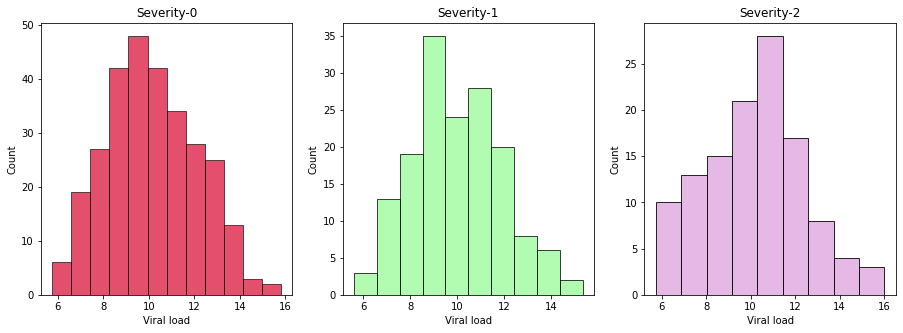

In [447]:
fig, axs = plt.subplots(nrows = 1,  ncols = 3,  figsize=(5, 5))
sns.histplot(x = vl_0,  ax = axs[0], color = "crimson").set(title = "Severity-0", xlabel = "Viral load")
sns.histplot(x = vl_1 , ax = axs[1], color = "palegreen").set(title = "Severity-1", xlabel = "Viral load")
sns.histplot(x = vl_2 , ax = axs[2], color = "plum").set(title = "Severity-2", xlabel = "Viral load")

plt.subplots_adjust(right = 2.5)
plt.show()

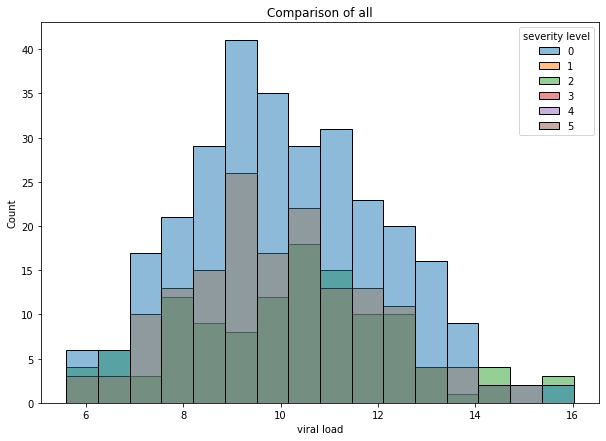

In [456]:
plt.figure(figsize=(10, 7))

fem_sev = ap[(ap["sex"] == 'female') & (ap["severity level"].isin([0, 1, 2]))]
#fem_sev["severity level"].value_counts()
sns.histplot(data = fem_sev, x = "viral load", hue = "severity level").set(title = "Comparison of all")
plt.show()

In [440]:
# Levene's test for equal variance
# Null Hyp => Variances are equal
# Alt Hyp => Atleast one variance is not same
# As we can know, the distribution is normally distributed, therefore we will use 
# center = ‘mean’ : Recommended for symmetric, moderate-tailed distributions. 

vl_0 = ap[(ap["severity level"] == 0) & (ap["sex"] == "female")]["viral load"]
vl_1 = ap[(ap["severity level"] == 1) & (ap["sex"] == "female")]["viral load"]
vl_2 = ap[(ap["severity level"] == 2) & (ap["sex"] == "female")]["viral load"]

alpha = 0.05

l_stat, p_val = levene(vl_0, vl_1, vl_2, center = "mean")
print("L-statistic", l_stat, "P-value", p_val)

if(p_val < alpha):
    print("Reject Null Hyp - All samples dont have similar variance")
else:
    print("Fail to reject Null Hyp - All samples have similar variance")

L-statistic 0.9516313931399634 P-value 0.38673078296344054
Fail to reject Null Hyp - All samples have similar variance


**Now we will perform 1-way ANOVA with C.I = 95%**

In [442]:
alpha = 0.05

f_stat, p_val = f_oneway(vl_0, vl_1, vl_2, axis = 0)
print("F-statistic", f_stat, "P-value", p_val)

if(p_val < alpha):
    print("Reject Null Hyp - Means differ signifcantly")
else:
    print("Fail to reject Null Hyp - Means are similar")

F-statistic 0.3355061434584082 P-value 0.7151189650367746
Fail to reject Null Hyp - Means are similar


**Hence, with 95% confidence, we can say that the mean viral load in women with severity levels of 0,1,2 are similar**

<h3><center><u> Conclusions </u></center></h3>

<ol>
    <li> The <b>major factor</b> affecting hospitalization charges in Apollo Hospitals is whether or not the person has been <b>Smoking</b>. Apart from this, factors such as <b>age, gender, and region</b> too play a significant role in determining the hospitalization charges</li>
    <li> We were able to prove through Hypothesis tests that mean hospitalization charge for smokers was much greater than that for non-smokers</li>
    <li> We also proved that, <b>viral loads seen in men and women do not have a significant difference</b></li>
    <li> We proved, with <b>93%</b> confidence that, <b>proportion of people smoking differs from region to region</b>. This was caused mainly due to the <b>SouthEast region</b>. If we would have performed the test for the other regions excluding it, we would have got a different result</li>
    <li> Finally, we proved that mean viral load in women with various severity levels are similar</li>
<ol>